# Goal

* Compare the Cell x Gene versus scBaseCamp

# Var

In [1]:
db_uri = "/scratch/multiomics/nickyoungblut/tiledb-loader/tiledb-soma_GeneFull_Ex50pAS"

# Init

In [2]:
import pandas as pd
import plotnine as pn
import tiledbsoma
import tiledbsoma.io
import cellxgene_census
# set plotnine theme
pn.theme_set(pn.theme_bw())

# Load

### scBaseCamp

In [3]:
with tiledbsoma.open(db_uri) as exp:
    print(exp.obs.schema)

soma_joinid: int64 not null
obs_id: large_string
gene_count: int64
umi_count: float
barcode: large_string
SRX_accession: dictionary<values=string, indices=int32, ordered=0>
lib_prep: dictionary<values=string, indices=int32, ordered=0>
tech_10x: dictionary<values=string, indices=int32, ordered=0>
organism: dictionary<values=string, indices=int32, ordered=0>
tissue: dictionary<values=string, indices=int32, ordered=0>
disease: dictionary<values=string, indices=int32, ordered=0>
purturbation: dictionary<values=string, indices=int32, ordered=0>
cell_line: dictionary<values=string, indices=int32, ordered=0>
czi_collection_id: dictionary<values=string, indices=int32, ordered=0>
czi_collection_name: dictionary<values=string, indices=int32, ordered=0>


In [4]:
# load scBaseCamp data
target_cols = ["SRX_accession", "lib_prep", "organism", "tissue", "disease"]

with tiledbsoma.open(db_uri) as exp:
    scbc_metadata = (
        exp.obs.read(column_names=target_cols)
        .concat()
        .group_by(target_cols)
        .aggregate([
            ([], 'count_all'),
        ])
        .to_pandas()
    )
scbc_metadata["dataset"] = "scBaseCamp"
scbc_metadata

,SRX_accession,lib_prep,organism,tissue,disease,count_all,dataset
0,SRX10681588,10x_Genomics,human,blood,not specified,7576,scBaseCamp
1,SRX18700948,10x_Genomics,human,blood,severe dengue,6823,scBaseCamp
2,SRX18700950,10x_Genomics,human,blood,severe dengue,4385,scBaseCamp
3,SRX18700949,10x_Genomics,human,blood,severe dengue,1928,scBaseCamp
4,SRX19713411,10x_Genomics,human,adipose differentiating cells,none,5879,scBaseCamp
...,...,...,...,...,...,...,...
30390,SRX23619490,10x_Genomics,mouse,brain,none,4750,scBaseCamp
30391,SRX22232247,10x_Genomics,mouse,hippocampus - CA,not specified,6758,scBaseCamp
30392,SRX22232248,10x_Genomics,mouse,CTXsp - CLA-EP-LA-BLA-BMA-PA,other,7344,scBaseCamp
30393,SRX21175585,10x_Genomics,mouse,posterior piriform cortex,unsure,858,scBaseCamp


In [5]:
# filter organism
scbc_metadata_f = scbc_metadata[(scbc_metadata["organism"] != "other") & (scbc_metadata["tissue"].notna())]
scbc_metadata_f["organism"].value_counts()

organism
human                      16077
mouse                      12212
Macaca mulatta               587
Danio rerio                  461
Sus scrofa                   197
Drosophila melanogaster      181
Arabidopsis thaliana         175
Gallus gallus                104
Heterocephalus glaber         79
Caenorhabditis elegans        52
Pan troglodytes               49
Bos taurus                    48
Oryctolagus cuniculus         34
Zea mays                      33
Oryza sativa                  31
Callithrix jacchus            24
Ovis aries                    20
Equus caballus                11
Solanum lycopersicum          10
Schistosoma mansoni            7
Gorilla gorilla                2
NaN                            0
Rattus norvegicus              0
other                          0
Homo sapiens                   0
Mus musculus                   0
Name: count, dtype: int64

In [6]:
# rename human and mouse to binomial
def rename_organism(x):
    if x == "human":
        return "Homo sapiens"
    elif x == "mouse":
        return "Mus musculus"
    return x

scbc_metadata_f.loc[:, "organism"] = scbc_metadata_f["organism"].apply(rename_organism)
scbc_metadata_f["organism"].value_counts()

organism
Homo sapiens               16077
Mus musculus               12212
Macaca mulatta               587
Danio rerio                  461
Sus scrofa                   197
Drosophila melanogaster      181
Arabidopsis thaliana         175
Gallus gallus                104
Heterocephalus glaber         79
Caenorhabditis elegans        52
Pan troglodytes               49
Bos taurus                    48
Oryctolagus cuniculus         34
Zea mays                      33
Oryza sativa                  31
Callithrix jacchus            24
Ovis aries                    20
Equus caballus                11
Solanum lycopersicum          10
Schistosoma mansoni            7
Gorilla gorilla                2
human                          0
NaN                            0
mouse                          0
other                          0
Rattus norvegicus              0
Name: count, dtype: int64

In [7]:
# tissue map
tissue_map = pd.read_csv("/home/nickyoungblut/dev/nextflow/scRecounter/scripts/gcp-upload/data/2025-02-20_tissue_categories.csv")
tissue_map 

,tissue,category
0,2 layer spheroid,other
1,"3 layer spheroid channel 1,epithelial",other
2,3 layer spheroid channel 2,other
3,3D healthy skin model,skin of body
4,A549 cells,lung
...,...,...
3742,zebrafish embryo,embryo
3743,zebrafish larva,other
3744,zebrafish trunks at yolk extension,embryo
3745,ileal,small intestine


In [8]:
# merge tissue
scbc_metadata_f = scbc_metadata_f.merge(tissue_map, on="tissue", how="inner")
scbc_metadata_f

,SRX_accession,lib_prep,organism,tissue,disease,count_all,dataset,category
0,SRX10681588,10x_Genomics,Homo sapiens,blood,not specified,7576,scBaseCamp,blood
1,SRX18700948,10x_Genomics,Homo sapiens,blood,severe dengue,6823,scBaseCamp,blood
2,SRX18700950,10x_Genomics,Homo sapiens,blood,severe dengue,4385,scBaseCamp,blood
3,SRX18700949,10x_Genomics,Homo sapiens,blood,severe dengue,1928,scBaseCamp,blood
4,SRX19713411,10x_Genomics,Homo sapiens,adipose differentiating cells,none,5879,scBaseCamp,adipose tissue
...,...,...,...,...,...,...,...,...
30389,SRX23619490,10x_Genomics,Mus musculus,brain,none,4750,scBaseCamp,brain
30390,SRX22232247,10x_Genomics,Mus musculus,hippocampus - CA,not specified,6758,scBaseCamp,brain
30391,SRX22232248,10x_Genomics,Mus musculus,CTXsp - CLA-EP-LA-BLA-BMA-PA,other,7344,scBaseCamp,cortex
30392,SRX21175585,10x_Genomics,Mus musculus,posterior piriform cortex,unsure,858,scBaseCamp,brain


### Cell x Gene

In [9]:
with cellxgene_census.open_soma(census_version="2025-01-30") as census:
    print(census["census_data"]["homo_sapiens"].obs.schema)

soma_joinid: int64 not null
dataset_id: dictionary<values=string, indices=int16, ordered=0>
assay: dictionary<values=string, indices=int8, ordered=0>
assay_ontology_term_id: dictionary<values=string, indices=int8, ordered=0>
cell_type: dictionary<values=string, indices=int16, ordered=0>
cell_type_ontology_term_id: dictionary<values=string, indices=int16, ordered=0>
development_stage: dictionary<values=string, indices=int16, ordered=0>
development_stage_ontology_term_id: dictionary<values=string, indices=int16, ordered=0>
disease: dictionary<values=string, indices=int16, ordered=0>
disease_ontology_term_id: dictionary<values=string, indices=int16, ordered=0>
donor_id: dictionary<values=string, indices=int16, ordered=0>
is_primary_data: bool
observation_joinid: large_string
self_reported_ethnicity: dictionary<values=string, indices=int8, ordered=0>
self_reported_ethnicity_ontology_term_id: dictionary<values=string, indices=int8, ordered=0>
sex: dictionary<values=string, indices=int8, ord

In [10]:
# load cell x gene obs metadata
target_cols = ["dataset_id", "assay", "tissue", "tissue_general", "disease"]

cxg_metadata = []
for organism,organism_str in {"homo_sapiens": "Homo sapiens", "mus_musculus" : "Mus musculus"}.items():
    with cellxgene_census.open_soma(census_version="2025-01-30") as census:
        df = (
            census["census_data"][organism].obs
            .read(column_names = target_cols).concat()
            .group_by(target_cols).aggregate([([], 'count_all')]).to_pandas()
        )
        df["organism"] = organism_str
        cxg_metadata.append(df)

cxg_metadata = pd.concat(cxg_metadata).reset_index()
cxg_metadata["dataset"] = "Cell x Gene"
cxg_metadata

,index,dataset_id,assay,tissue,tissue_general,disease,count_all,organism,dataset
0,0,d7476ae2-e320-4703-8304-da5c42627e71,10x 3' v3,liver,liver,breast cancer,565,Homo sapiens,Cell x Gene
1,1,0895c838-e550-48a3-a777-dbcd35d30272,10x 3' v2,caudate lobe of liver,liver,normal,109,Homo sapiens,Cell x Gene
2,2,0895c838-e550-48a3-a777-dbcd35d30272,10x 3' v3,caudate lobe of liver,liver,normal,37,Homo sapiens,Cell x Gene
3,3,fbd69faa-b0c5-45ba-89c9-da938a7f5a14,10x 3' v2,thymus,endocrine gland,normal,537,Homo sapiens,Cell x Gene
4,4,fbd69faa-b0c5-45ba-89c9-da938a7f5a14,10x 5' v1,thymus,endocrine gland,normal,104,Homo sapiens,Cell x Gene
...,...,...,...,...,...,...,...,...,...
5108,431,b6f472f1-a58d-43a7-a898-2d6822a0b2b2,Smart-seq3,dorsal root ganglion,nervous system,normal,625,Mus musculus,Cell x Gene
5109,432,a91d5064-aba3-4688-9fcd-6187b2f435a4,sci-RNA-seq3,embryo,embryo,normal,2860465,Mus musculus,Cell x Gene
5110,433,0bce33ed-455c-4e12-93f8-b7b04a2de4a1,sci-RNA-seq3,embryo,embryo,normal,2863559,Mus musculus,Cell x Gene
5111,434,dcfa2614-7ca7-4d82-814c-350626eccb26,sci-RNA-seq3,embryo,embryo,normal,3267338,Mus musculus,Cell x Gene


In [ ]:
# filter to 10x
# tech_10x = [
#     "10x 3' v3",
#     "10x 3' v2",
#     "10x 5' v1",
#     "10x 5' v2",
#     "10x 5' transcription profiling",
#     "10x 3' v1",
#     "10x 3' transcription profiling",
#     "10x gene expression flex"
# ]
cxg_metadata_f = cxg_metadata#[cxg_metadata["assay"].isin(tech_10x)]
cxg_metadata_f["assay"].value_counts()

assay
10x 3' v3                                   2613
10x 3' v2                                   1158
Smart-seq2                                   367
10x 5' v1                                    289
10x 5' v2                                    154
TruDrop                                       73
10x 5' transcription profiling                72
sci-RNA-seq3                                  63
Drop-seq                                      60
microwell-seq                                 59
Smart-seq v4                                  32
10x 3' v1                                     27
BD Rhapsody Whole Transcriptome Analysis      20
Seq-Well                                      18
10x 3' transcription profiling                18
inDrop                                        16
Smart-seq3                                    11
CEL-seq2                                      11
10x gene expression flex                      10
Seq-Well S3                                    7
GEXSCOPE techn

# Cell count

## Cells per collection

In [ ]:
# create metadata query
obs_query = tiledbsoma.AxisQuery(value_filter='czi_collection_name not in ["None", "NaN"]')

# obs counts per czi collection
with tiledbsoma.Experiment.open(db_uri) as exp:
    scbc_czi_metadata = (
        exp.axis_query("RNA", obs_query=obs_query)
        .obs()
        .concat()
        .group_by("czi_collection_id")
        .aggregate([
            ([], 'count_all'),
        ])
        .to_pandas()
    )
scbc_czi_metadata["dataset"] = "scBaseCamp"
scbc_czi_metadata

,czi_collection_id,count_all
0,f86d6317-7215-409e-bfda-3f4ded3dadaa,676803
1,43b45a20-a969-49ac-a8e8-8c84b211bd01,114325
2,ecb739c5-fe0d-4b48-81c6-217c4d64eec4,373636
3,38833785-fac5-48fd-944a-0f62a4c23ed1,12149
4,0a77d4c0-d5d0-40f0-aa1a-5e1429bcbd7e,116131
...,...,...
76,257ce7fb-ab27-4772-8a06-9fe8385816b2,179687
77,4fa07e63-f712-4d8c-b885-2c515b5e2743,45330
78,99f1515b-46a2-4bc4-94c3-f62659dc1eb4,10394
79,92fde064-2fb4-41f8-b85c-c6904000b859,1853


In [41]:
#scbc_czi_metadata["count_all"].sum()
scbc_czi_metadata["czi_collection_id"].nunique()

81

In [24]:
# summarize count_all by dataset_id
cxg_metadata_fs = cxg_metadata_f.groupby("dataset_id").agg({"count_all": "sum"}).reset_index().rename(columns={"dataset_id": "czi_collection_id"})
cxg_metadata_fs["dataset"] = "Cell x Gene"
print(cxg_metadata_fs.shape)
cxg_metadata_fs.head()

(1054, 3)


,czi_collection_id,count_all,dataset
0,0041b9c3-6a49-4bf7-8514-9bc7190067a7,17786,Cell x Gene
1,00476f9f-ebc1-4b72-b541-32f912ce36ea,10099,Cell x Gene
2,00593d17-0693-4646-acad-89dbefba11bb,29078,Cell x Gene
3,0087cde2-967d-4f7c-8e6e-40e4c9ad1891,5399,Cell x Gene
4,00e5dedd-b9b7-43be-8c28-b0e5c6414a62,21422,Cell x Gene


## Tissue comparison

In [11]:
# filter to mammals
mammals = [
    "Homo sapiens",
    "Mus musculus",
    "Macaca mulatta",
    "Sus scrofa",
    "Gallus gallus",
    "Heterocephalus glaber",
    "Pan troglodytes",
    "Bos taurus",
    "Oryctolagus cuniculus",
    "Callithrix jacchus",
    "Ovis aries",
    "Equus caballus",
    "Gorilla gorilla"
]
scbc_metadata_f_mam = scbc_metadata_f[scbc_metadata_f["organism"].isin(mammals)]
scbc_metadata_f_mam["organism"].value_counts()

organism
Homo sapiens               16077
Mus musculus               12212
Macaca mulatta               587
Sus scrofa                   197
Gallus gallus                104
Heterocephalus glaber         79
Pan troglodytes               49
Bos taurus                    48
Oryctolagus cuniculus         34
Callithrix jacchus            24
Ovis aries                    20
Equus caballus                11
Gorilla gorilla                2
NaN                            0
human                          0
mouse                          0
Danio rerio                    0
Drosophila melanogaster        0
Schistosoma mansoni            0
Solanum lycopersicum           0
Arabidopsis thaliana           0
Caenorhabditis elegans         0
Zea mays                       0
Oryza sativa                   0
other                          0
Rattus norvegicus              0
Name: count, dtype: int64

In [12]:
# concat with cell x gene and add total counts
tissue_all = pd.concat([
    scbc_metadata_f_mam[["dataset", "category", "count_all"]].rename(columns={"category" : "tissue"}),
    cxg_metadata_f[["dataset", "tissue_general", "count_all"]].rename(columns={"tissue_general" : "tissue"})
])

# filter out "other" tissue
tissue_all = tissue_all[tissue_all["tissue"] != "other"]

# add total per tissue using transform
tissue_all['total_per_tissue'] = tissue_all.groupby('tissue')['count_all'].transform('sum')

# group by dataset and tissue
tissue_all = tissue_all.groupby(["dataset", "tissue"]).agg({
    'count_all': 'sum',
    'total_per_tissue': 'first'
}).reset_index()

tissue_all

,dataset,tissue,count_all,total_per_tissue
0,Cell x Gene,abdomen,414553,637890
1,Cell x Gene,adipose tissue,1515281,3610413
2,Cell x Gene,adrenal gland,560114,1013431
3,Cell x Gene,axilla,144461,157333
4,Cell x Gene,bladder organ,208203,208203
...,...,...,...,...
142,scBaseCamp,ureter,12064,87308
143,scBaseCamp,urinary bladder,645829,717396
144,scBaseCamp,uterus,2113415,2700977
145,scBaseCamp,vasculature,3779114,4213813


In [13]:
# filter to top 30 tissues
top_n = tissue_all.sort_values('total_per_tissue', ascending=False)["tissue"].unique()[:30]
tissue_all_f = tissue_all[tissue_all["tissue"].isin(top_n)]
tissue_all_f

,dataset,tissue,count_all,total_per_tissue
1,Cell x Gene,adipose tissue,1515281,3610413
5,Cell x Gene,blood,12750527,49076639
6,Cell x Gene,bone marrow,1418329,12025579
7,Cell x Gene,brain,42469540,72521702
8,Cell x Gene,breast,5814678,11739627
9,Cell x Gene,central nervous system,97054,2216154
11,Cell x Gene,colon,1098165,5084146
12,Cell x Gene,cortex,456334,2116300
14,Cell x Gene,embryo,34517150,39218004
15,Cell x Gene,endocrine gland,2125912,3055852


In [14]:
# sum by dataset
tissue_all_f.groupby(["dataset"]).agg({
    'count_all': 'sum'
})

,count_all
dataset,
Cell x Gene,139955857
scBaseCamp,191101495


/tmp/ipykernel_481743/738242106.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


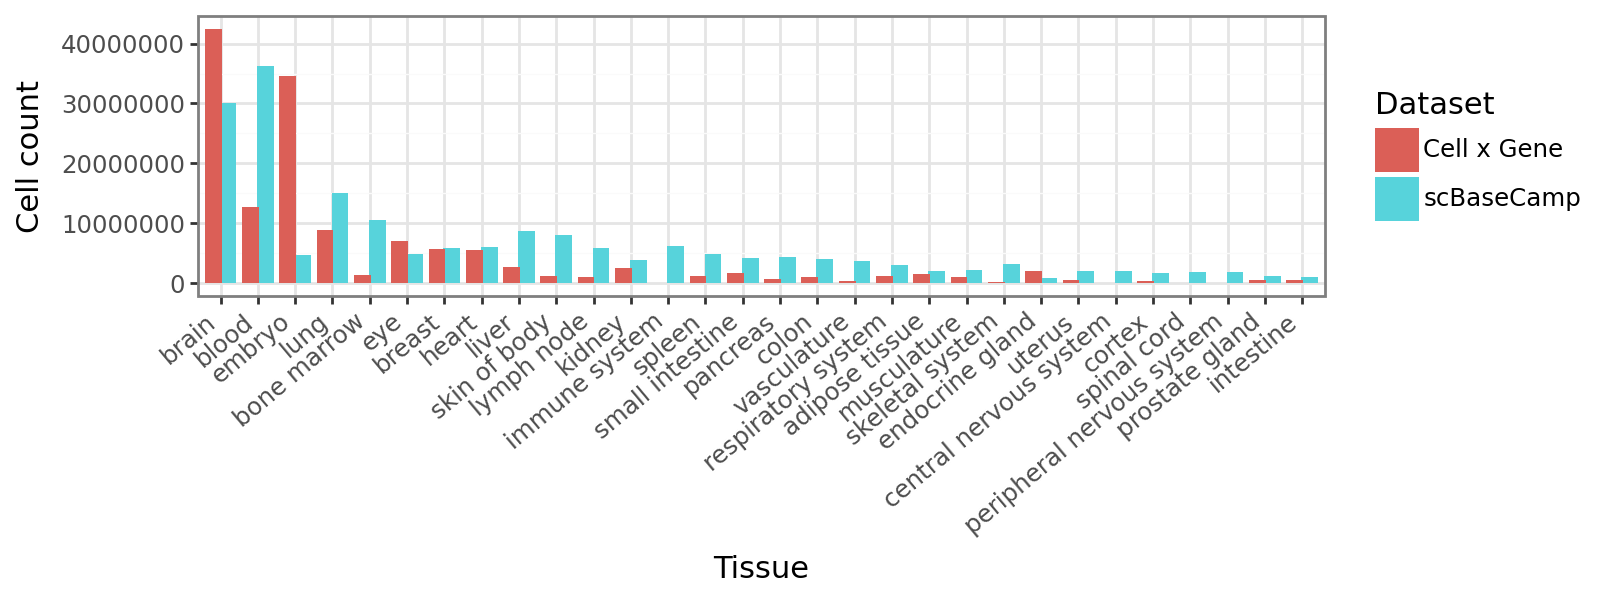

In [15]:
# plot cells per organism

## sort tissue by cell count
tissue_all_f['tissue'] = pd.Categorical(
    tissue_all_f['tissue'], 
    categories=tissue_all_f.sort_values('total_per_tissue', ascending=False)['tissue'].unique().tolist(), 
    ordered=True
)

## plot
p = (
    pn.ggplot(tissue_all_f, pn.aes(x="tissue", y="count_all", fill="dataset")) + 
    pn.geom_col(position=pn.position_dodge(width=0.8)) +
    #pn.scale_y_continuous(trans='sqrt', breaks=[1e6, 5e6, 1e7, 2e7, 3e7, 4e7]) +
    #pn.scale_y_continuous(trans='log10') +
    pn.labs(x="Tissue", y="Cell count", fill="Dataset") +
    pn.theme(
        figure_size=(8,3),
        axis_text_x=pn.element_text(angle=40, hjust=1)
    ))
p

In [25]:
# save as svg
p.save("tissue_cell_count.svg", format="svg")

/home/nickyoungblut/miniforge3/envs/tiledb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 8 x 3 in image.
/home/nickyoungblut/miniforge3/envs/tiledb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: tissue_cell_count.svg


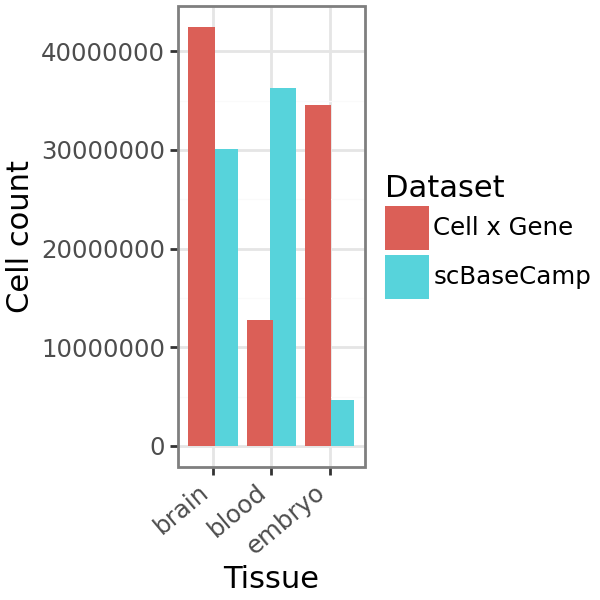

In [68]:
target_cols = ["brain", "blood", "embryo"]
## plot
p = (
    pn.ggplot(
        tissue_all_f[tissue_all_f["tissue"].isin(target_cols)],
        pn.aes(x="tissue", y="count_all", fill="dataset")
    ) + 
    pn.geom_col(position=pn.position_dodge(width=0.8)) +
    pn.labs(x="Tissue", y="Cell count", fill="Dataset") +
    pn.theme(
        figure_size=(3,3),
        axis_text_x=pn.element_text(angle=40, hjust=1)
    ))
p

In [69]:
p.save("tissue_cell_count_high.svg", format="svg")

/home/nickyoungblut/miniforge3/envs/tiledb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 3 x 3 in image.
/home/nickyoungblut/miniforge3/envs/tiledb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: tissue_cell_count_high.svg


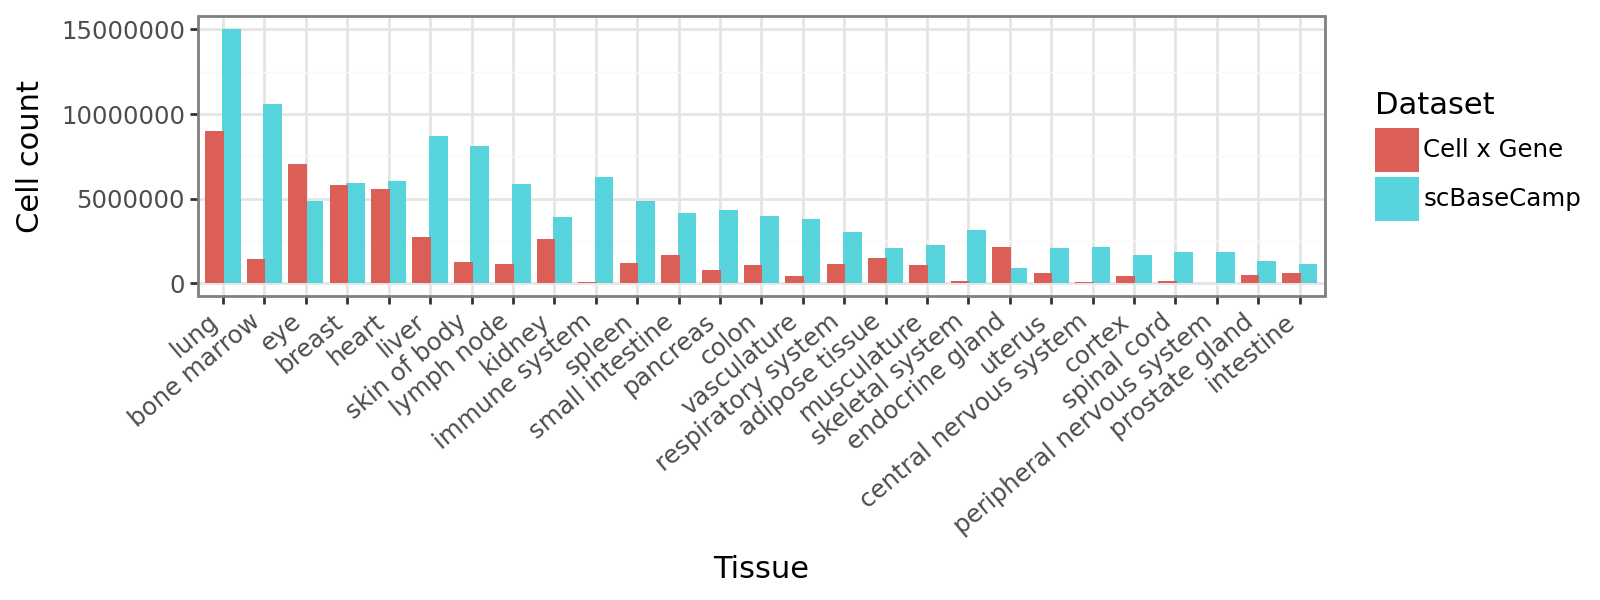

In [65]:
target_cols = ["brain", "blood", "embryo"]
## plot
p = (
    pn.ggplot(
        tissue_all_f[~tissue_all_f["tissue"].isin(target_cols)],
        pn.aes(x="tissue", y="count_all", fill="dataset")
    ) + 
    pn.geom_col(position=pn.position_dodge(width=0.8)) +
    pn.labs(x="Tissue", y="Cell count", fill="Dataset") +
    pn.theme(
        figure_size=(8,3),
        axis_text_x=pn.element_text(angle=40, hjust=1)
    ))
p

In [67]:
p.save("tissue_cell_count_low.svg", format="svg")

/home/nickyoungblut/miniforge3/envs/tiledb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 8 x 3 in image.
/home/nickyoungblut/miniforge3/envs/tiledb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: tissue_cell_count_low.svg


## Organism comparison

In [16]:
czi_species_tissue = pd.read_csv("data/czi_species_tissue.tsv", sep="\t")
czi_species_tissue["dataset"] = "Cell x Gene"
czi_species_tissue

,organism,tissue,count,dataset
0,Callithrix jacchus,Brodmann (1909) area 19,0,Cell x Gene
1,Callithrix jacchus,Brodmann (1909) area 23,21148,Cell x Gene
2,Callithrix jacchus,Brodmann (1909) area 25,31538,Cell x Gene
3,Callithrix jacchus,amygdala,0,Cell x Gene
4,Callithrix jacchus,anterior cingulate cortex,0,Cell x Gene
...,...,...,...,...
170,Sus scrofa,superior parietal cortex,0,Cell x Gene
171,Sus scrofa,superior temporal sulcus,0,Cell x Gene
172,Sus scrofa,temporal cortex,0,Cell x Gene
173,Sus scrofa,temporal lobe,0,Cell x Gene


In [17]:
cxg_metadata_ff = pd.concat([
    cxg_metadata_f[["organism", "tissue_general", "count_all", "dataset"]].rename(columns={"tissue_general" : "tissue", "count_all" : "count"}),
    czi_species_tissue
]).groupby(["organism", "dataset"]).agg({
    "count": "sum"
}).reset_index()

cxg_metadata_ff

,organism,dataset,count
0,Callithrix jacchus,Cell x Gene,629571
1,Gorilla gorilla,Cell x Gene,139945
2,Homo sapiens,Cell x Gene,106118167
3,Macaca mulatta,Cell x Gene,2808972
4,Mus musculus,Cell x Gene,42776863
5,Pan troglodytes,Cell x Gene,271028
6,Sus scrofa,Cell x Gene,22056


In [18]:
scbc_metadata_ff = scbc_metadata_f[["organism", "dataset", "count_all"]].groupby(["organism", "dataset"]).agg({"count_all": "sum"}).reset_index().rename(columns={"count_all": "count"})
scbc_metadata_ff = scbc_metadata_ff[scbc_metadata_ff["count"] > 0]
scbc_metadata_ff

/tmp/ipykernel_481743/3488309384.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,organism,dataset,count
3,Bos taurus,scBaseCamp,410785
4,Danio rerio,scBaseCamp,3750070
5,Drosophila melanogaster,scBaseCamp,1684792
6,Heterocephalus glaber,scBaseCamp,467872
7,Macaca mulatta,scBaseCamp,4057401
8,Oryctolagus cuniculus,scBaseCamp,396294
9,Schistosoma mansoni,scBaseCamp,33165
10,Sus scrofa,scBaseCamp,1812234
11,Arabidopsis thaliana,scBaseCamp,1618082
12,Caenorhabditis elegans,scBaseCamp,278649


In [19]:
organism_all = pd.concat([scbc_metadata_ff, cxg_metadata_ff])
organism_all['total'] = organism_all.groupby('organism')['count'].transform('sum')
organism_all

,organism,dataset,count,total
3,Bos taurus,scBaseCamp,410785,410785
4,Danio rerio,scBaseCamp,3750070,3750070
5,Drosophila melanogaster,scBaseCamp,1684792,1684792
6,Heterocephalus glaber,scBaseCamp,467872,467872
7,Macaca mulatta,scBaseCamp,4057401,6866373
8,Oryctolagus cuniculus,scBaseCamp,396294,396294
9,Schistosoma mansoni,scBaseCamp,33165,33165
10,Sus scrofa,scBaseCamp,1812234,1834290
11,Arabidopsis thaliana,scBaseCamp,1618082,1618082
12,Caenorhabditis elegans,scBaseCamp,278649,278649


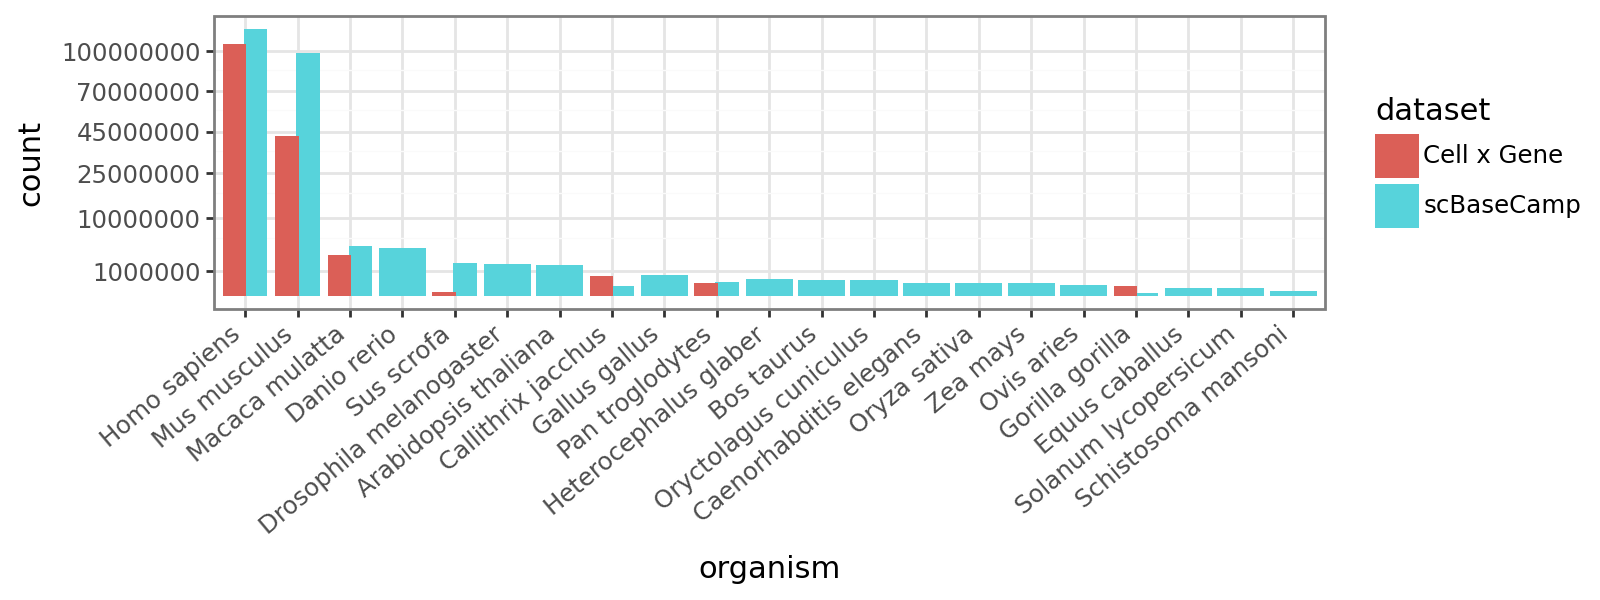

In [20]:
# plot

## sort organism by cell count
organism_all['organism'] = pd.Categorical(
    organism_all['organism'], 
    categories=organism_all.sort_values('total', ascending=False)['organism'].unique().tolist(), 
    ordered=True
)

## plot
p = (
    pn.ggplot(organism_all, pn.aes(x="organism", y="count", fill="dataset")) + 
    pn.geom_col(position=pn.position_dodge(width=0.8)) +
    pn.scale_y_continuous(trans = "sqrt", breaks = [1e6, 1e7, 2.5e7, 4.5e7, 7e7, 1e8]) +
    #pn.scale_y_continuous(trans = "log10") +
    #pn.labs(x="Organism", y="Cell count", fill="Dataset") +
    pn.theme(
        figure_size=(8,3),
        axis_text_x=pn.element_text(angle=40, hjust=1)
    ))
p

In [89]:
# save
p.save("organism_cell_count_sqrt.svg", format="svg")

/home/nickyoungblut/miniforge3/envs/tiledb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 8 x 3 in image.
/home/nickyoungblut/miniforge3/envs/tiledb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: organism_cell_count_sqrt.svg


In [23]:
# facet by mouse/human versus others
organism_all["facet"] = organism_all["organism"].apply(lambda x: "Human/Mouse" if x in ["Homo sapiens", "Mus musculus"] else "Others")
organism_all

,organism,dataset,count,total,facet
3,Bos taurus,scBaseCamp,410785,410785,Others
4,Danio rerio,scBaseCamp,3750070,3750070,Others
5,Drosophila melanogaster,scBaseCamp,1684792,1684792,Others
6,Heterocephalus glaber,scBaseCamp,467872,467872,Others
7,Macaca mulatta,scBaseCamp,4057401,6866373,Others
8,Oryctolagus cuniculus,scBaseCamp,396294,396294,Others
9,Schistosoma mansoni,scBaseCamp,33165,33165,Others
10,Sus scrofa,scBaseCamp,1812234,1834290,Others
11,Arabidopsis thaliana,scBaseCamp,1618082,1618082,Others
12,Caenorhabditis elegans,scBaseCamp,278649,278649,Others


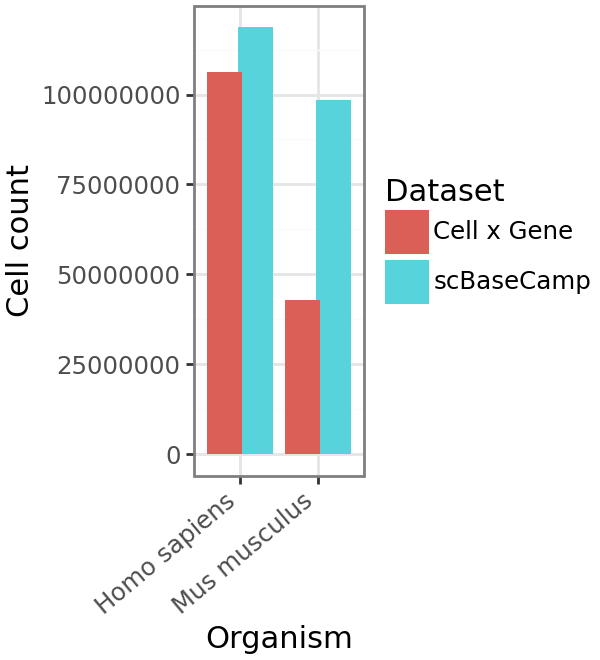

In [54]:
# plot
p = (
    pn.ggplot(
        organism_all[organism_all["facet"] == "Human/Mouse"], 
        pn.aes(x="organism", y="count", fill="dataset")
    ) + 
    pn.geom_col(position=pn.position_dodge(width=0.8)) +
    pn.labs(x="Organism", y="Cell count", fill="Dataset") +
    pn.theme(
        figure_size=(3,3.3),
        axis_text_x=pn.element_text(angle=40, hjust=1)
    ))
p

In [55]:
# save
p.save("organism_cell-count_human-mouse.svg", format="svg")

/home/nickyoungblut/miniforge3/envs/tiledb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 3 x 3.3 in image.
/home/nickyoungblut/miniforge3/envs/tiledb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: organism_cell-count_human-mouse.svg


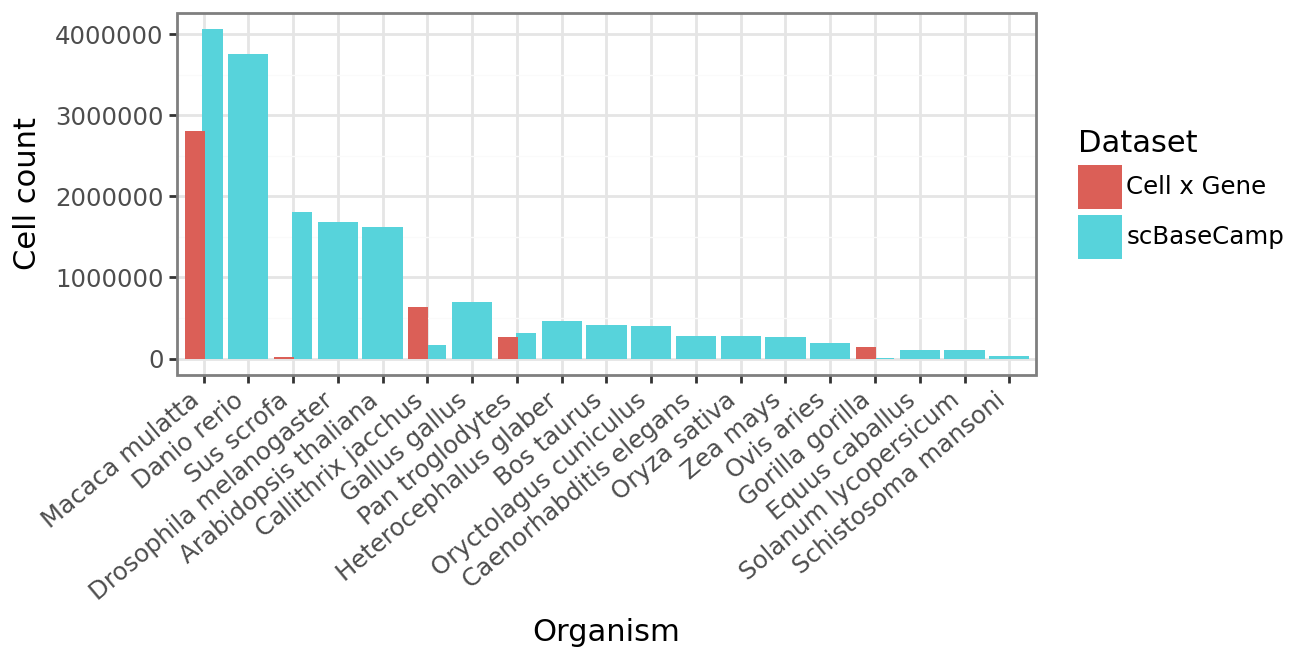

In [57]:
# plot
p = (
    pn.ggplot(
        organism_all[organism_all["facet"] == "Others"], 
        pn.aes(x="organism", y="count", fill="dataset")
    ) + 
    pn.geom_col(position=pn.position_dodge(width=0.8)) +
    pn.labs(x="Organism", y="Cell count", fill="Dataset") +
    pn.theme(
        figure_size=(6.5,3.3),
        axis_text_x=pn.element_text(angle=40, hjust=1)
    ))
p

In [58]:
# save
p.save("organism_cell-count_others.svg", format="svg")

/home/nickyoungblut/miniforge3/envs/tiledb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.5 x 3.3 in image.
/home/nickyoungblut/miniforge3/envs/tiledb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: organism_cell-count_others.svg


# Gene/UMI distribution

## Tissue

### Load scBaseCamp

In [3]:
# load scBaseCamp data
target_cols = ["tissue", "organism", "gene_count", "umi_count"]
with tiledbsoma.open(db_uri) as exp:
    scbc_metadata = (
        exp.obs.read(column_names=target_cols)
        .concat()
        .to_pandas()
    )

# filter to mammals
mammals = [
    "Homo sapiens",
    "Mus musculus",
    "Macaca mulatta",
    "Sus scrofa",
    "Gallus gallus",
    "Heterocephalus glaber",
    "Pan troglodytes",
    "Bos taurus",
    "Oryctolagus cuniculus",
    "Callithrix jacchus",
    "Ovis aries",
    "Equus caballus",
    "Gorilla gorilla"
]
scbc_metadata = scbc_metadata[scbc_metadata["organism"].isin(mammals)].reset_index(drop=True)
scbc_metadata["dataset"] = "scBaseCamp"
scbc_metadata

,tissue,organism,gene_count,umi_count,dataset
0,fetal lungs,Macaca mulatta,2653,5818.0,scBaseCamp
1,fetal lungs,Macaca mulatta,384,613.0,scBaseCamp
2,fetal lungs,Macaca mulatta,1667,2901.0,scBaseCamp
3,fetal lungs,Macaca mulatta,569,912.0,scBaseCamp
4,fetal lungs,Macaca mulatta,4905,13947.0,scBaseCamp
...,...,...,...,...,...
8627068,Bronchoalveolar lavage (BAL),Macaca mulatta,4984,26900.0,scBaseCamp
8627069,Bronchoalveolar lavage (BAL),Macaca mulatta,3020,10868.0,scBaseCamp
8627070,Bronchoalveolar lavage (BAL),Macaca mulatta,4914,23230.0,scBaseCamp
8627071,Bronchoalveolar lavage (BAL),Macaca mulatta,1740,3598.0,scBaseCamp


In [4]:
# tissue map
tissue_map = pd.read_csv("/home/nickyoungblut/dev/nextflow/scRecounter/scripts/gcp-upload/data/2025-02-20_tissue_categories.csv")
tissue_map 

,tissue,category
0,2 layer spheroid,other
1,"3 layer spheroid channel 1,epithelial",other
2,3 layer spheroid channel 2,other
3,3D healthy skin model,skin of body
4,A549 cells,lung
...,...,...
3742,zebrafish embryo,embryo
3743,zebrafish larva,other
3744,zebrafish trunks at yolk extension,embryo
3745,ileal,small intestine


In [5]:
# merge tissue
scbc_metadata = scbc_metadata.merge(tissue_map, on="tissue", how="inner").drop(columns=["tissue"]).rename(columns={"category": "tissue"})
scbc_metadata

,organism,gene_count,umi_count,dataset,tissue
0,Macaca mulatta,2653,5818.0,scBaseCamp,lung
1,Macaca mulatta,384,613.0,scBaseCamp,lung
2,Macaca mulatta,1667,2901.0,scBaseCamp,lung
3,Macaca mulatta,569,912.0,scBaseCamp,lung
4,Macaca mulatta,4905,13947.0,scBaseCamp,lung
...,...,...,...,...,...
8627068,Macaca mulatta,4984,26900.0,scBaseCamp,respiratory system
8627069,Macaca mulatta,3020,10868.0,scBaseCamp,respiratory system
8627070,Macaca mulatta,4914,23230.0,scBaseCamp,respiratory system
8627071,Macaca mulatta,1740,3598.0,scBaseCamp,respiratory system


### Cell x Gene

In [6]:
with cellxgene_census.open_soma(census_version="2025-01-30") as census:
    print(census["census_data"]["homo_sapiens"].obs.schema)

soma_joinid: int64 not null
dataset_id: dictionary<values=string, indices=int16, ordered=0>
assay: dictionary<values=string, indices=int8, ordered=0>
assay_ontology_term_id: dictionary<values=string, indices=int8, ordered=0>
cell_type: dictionary<values=string, indices=int16, ordered=0>
cell_type_ontology_term_id: dictionary<values=string, indices=int16, ordered=0>
development_stage: dictionary<values=string, indices=int16, ordered=0>
development_stage_ontology_term_id: dictionary<values=string, indices=int16, ordered=0>
disease: dictionary<values=string, indices=int16, ordered=0>
disease_ontology_term_id: dictionary<values=string, indices=int16, ordered=0>
donor_id: dictionary<values=string, indices=int16, ordered=0>
is_primary_data: bool
observation_joinid: large_string
self_reported_ethnicity: dictionary<values=string, indices=int8, ordered=0>
self_reported_ethnicity_ontology_term_id: dictionary<values=string, indices=int8, ordered=0>
sex: dictionary<values=string, indices=int8, ord

In [7]:
# load cell x gene obs metadata
target_cols = ["tissue_general", "nnz", "raw_sum"]

cxg_metadata = []
for organism,organism_str in {"homo_sapiens": "Homo sapiens", "mus_musculus" : "Mus musculus"}.items():
    with cellxgene_census.open_soma(census_version="2025-01-30") as census:
        df = (
            census["census_data"][organism].obs
            .read(column_names = target_cols)
            .concat()
            .to_pandas()
        )
        df["organism"] = organism_str
        cxg_metadata.append(
            df.rename(columns={"nnz" : "gene_count", "raw_sum" : "umi_count", "tissue_general": "tissue"})
        )

cxg_metadata = pd.concat(cxg_metadata).reset_index()
cxg_metadata["dataset"] = "Cell x Gene"
cxg_metadata

,index,tissue,gene_count,umi_count,organism,dataset
0,0,liver,7157,19641.0,Homo sapiens,Cell x Gene
1,1,liver,5388,17251.0,Homo sapiens,Cell x Gene
2,2,liver,3942,14631.0,Homo sapiens,Cell x Gene
3,3,liver,5011,13741.0,Homo sapiens,Cell x Gene
4,4,liver,4421,12702.0,Homo sapiens,Cell x Gene
...,...,...,...,...,...,...
148895025,42776858,embryo,555,683.0,Mus musculus,Cell x Gene
148895026,42776859,embryo,715,1133.0,Mus musculus,Cell x Gene
148895027,42776860,embryo,1731,2990.0,Mus musculus,Cell x Gene
148895028,42776861,embryo,2639,6247.0,Mus musculus,Cell x Gene


### Gene count

In [31]:
target_col = "gene_count"

In [32]:
# combine
all_metadata = pd.concat([
    scbc_metadata, #.head(n=1000000),
    cxg_metadata, #.head(n=1000000)
])
all_metadata = all_metadata[all_metadata["tissue"] != "other"]

print(all_metadata.shape)
all_metadata.head()

(157122985, 6)


,organism,gene_count,umi_count,dataset,tissue,index
0,Macaca mulatta,2653,5818.0,scBaseCamp,lung,NaN
1,Macaca mulatta,384,613.0,scBaseCamp,lung,NaN
2,Macaca mulatta,1667,2901.0,scBaseCamp,lung,NaN
3,Macaca mulatta,569,912.0,scBaseCamp,lung,NaN
4,Macaca mulatta,4905,13947.0,scBaseCamp,lung,NaN


In [33]:
# filter tissues not found in both datasets
to_rm = all_metadata.drop_duplicates(["tissue", "dataset"]).groupby(["tissue"]).size().to_frame().reset_index().rename(columns={0 : "count"})
to_rm = to_rm[to_rm["count"] < 2]["tissue"].unique()    

## filter
all_metadata = all_metadata[~all_metadata["tissue"].isin(to_rm)]
print(all_metadata.shape)
all_metadata.head()

(143764153, 6)


,organism,gene_count,umi_count,dataset,tissue,index
0,Macaca mulatta,2653,5818.0,scBaseCamp,lung,NaN
1,Macaca mulatta,384,613.0,scBaseCamp,lung,NaN
2,Macaca mulatta,1667,2901.0,scBaseCamp,lung,NaN
3,Macaca mulatta,569,912.0,scBaseCamp,lung,NaN
4,Macaca mulatta,4905,13947.0,scBaseCamp,lung,NaN


In [34]:
# agg by tissue and get median
all_metadata_s = all_metadata.groupby(["tissue"]).agg({target_col: "median"}).reset_index()
print(all_metadata_s.shape)
all_metadata_s.head()

(36, 2)


,tissue,gene_count
0,abdomen,1961.0
1,adipose tissue,1905.0
2,blood,1256.0
3,bone marrow,1345.0
4,brain,2933.0


In [35]:
# filter to top 30 tissues
top_n = all_metadata_s.sort_values(target_col, ascending=False)["tissue"].unique()[:30]
all_metadata = all_metadata[all_metadata["tissue"].isin(top_n)]
all_metadata

,organism,gene_count,umi_count,dataset,tissue,index
0,Macaca mulatta,2653,5818.0,scBaseCamp,lung,NaN
1,Macaca mulatta,384,613.0,scBaseCamp,lung,NaN
2,Macaca mulatta,1667,2901.0,scBaseCamp,lung,NaN
3,Macaca mulatta,569,912.0,scBaseCamp,lung,NaN
4,Macaca mulatta,4905,13947.0,scBaseCamp,lung,NaN
...,...,...,...,...,...,...
148895025,Mus musculus,555,683.0,Cell x Gene,embryo,42776858.0
148895026,Mus musculus,715,1133.0,Cell x Gene,embryo,42776859.0
148895027,Mus musculus,1731,2990.0,Cell x Gene,embryo,42776860.0
148895028,Mus musculus,2639,6247.0,Cell x Gene,embryo,42776861.0


In [36]:
# add median column, agg by tissue
all_metadata['median'] = all_metadata.groupby('tissue')[target_col].transform('median')
print(all_metadata.shape)
all_metadata.head()

(119749607, 7)


,organism,gene_count,umi_count,dataset,tissue,index,median
0,Macaca mulatta,2653,5818.0,scBaseCamp,lung,NaN,1472.0
1,Macaca mulatta,384,613.0,scBaseCamp,lung,NaN,1472.0
2,Macaca mulatta,1667,2901.0,scBaseCamp,lung,NaN,1472.0
3,Macaca mulatta,569,912.0,scBaseCamp,lung,NaN,1472.0
4,Macaca mulatta,4905,13947.0,scBaseCamp,lung,NaN,1472.0


In [37]:
# calculate boxplot values by tissue and dataset
box_stats = (
    all_metadata.groupby(['tissue', 'dataset'])[target_col]
    .describe(percentiles=[0.25, 0.5, 0.75])
    .reset_index()
).rename({"25%" : "lower", "50%" : "middle", "75%" : "upper"}, axis=1)
# calc IQR
box_stats["iqr"] = box_stats["upper"] - box_stats["lower"]
# calc whiskers
box_stats["ymin"] = box_stats["lower"] - 1.5 * box_stats["iqr"]
box_stats["ymin"] = box_stats["ymin"].apply(lambda x: 0 if x < 0 else x)
box_stats["ymax"] = box_stats["upper"] + 1.5 * box_stats["iqr"]

# results
print(box_stats.shape)
box_stats.head()

(60, 13)


,tissue,dataset,count,mean,std,min,lower,middle,upper,max,iqr,ymin,ymax
0,abdomen,Cell x Gene,414553.0,2316.410242,1326.306125,496.0,1286.0,1973.0,3124.0,11769.0,1838.0,0.0,5881.00
1,abdomen,scBaseCamp,6939.0,1650.089927,729.283037,37.0,1110.0,1663.0,2124.5,5861.0,1014.5,0.0,3646.25
2,adipose tissue,Cell x Gene,1515281.0,2190.815861,1311.909523,20.0,1244.0,1887.0,2826.0,14924.0,1582.0,0.0,5199.00
3,adipose tissue,scBaseCamp,31830.0,3074.099529,1450.876089,28.0,2158.0,3148.0,4016.0,9467.0,1858.0,0.0,6803.00
4,brain,Cell x Gene,42469540.0,3555.498469,2414.445654,33.0,1613.0,2985.0,5202.0,22094.0,3589.0,0.0,10585.50


In [38]:
# ## sort by median
# all_metadata['tissue'] = pd.Categorical(
#     all_metadata['tissue'], 
#     categories=all_metadata.sort_values('median', ascending=False)['tissue'].unique().tolist(), 
#     ordered=True
# )

In [39]:
# agg by tissue and get median
box_stats_s = box_stats.groupby(["tissue"]).agg({"middle": "mean"}).reset_index()

## sort by median
box_stats['tissue'] = pd.Categorical(
    box_stats['tissue'], 
    categories=box_stats_s.sort_values('middle', ascending=False)['tissue'].unique().tolist(), 
    ordered=True
)

print(box_stats.shape)
box_stats.head()

(60, 13)


,tissue,dataset,count,mean,std,min,lower,middle,upper,max,iqr,ymin,ymax
0,abdomen,Cell x Gene,414553.0,2316.410242,1326.306125,496.0,1286.0,1973.0,3124.0,11769.0,1838.0,0.0,5881.00
1,abdomen,scBaseCamp,6939.0,1650.089927,729.283037,37.0,1110.0,1663.0,2124.5,5861.0,1014.5,0.0,3646.25
2,adipose tissue,Cell x Gene,1515281.0,2190.815861,1311.909523,20.0,1244.0,1887.0,2826.0,14924.0,1582.0,0.0,5199.00
3,adipose tissue,scBaseCamp,31830.0,3074.099529,1450.876089,28.0,2158.0,3148.0,4016.0,9467.0,1858.0,0.0,6803.00
4,brain,Cell x Gene,42469540.0,3555.498469,2414.445654,33.0,1613.0,2985.0,5202.0,22094.0,3589.0,0.0,10585.50


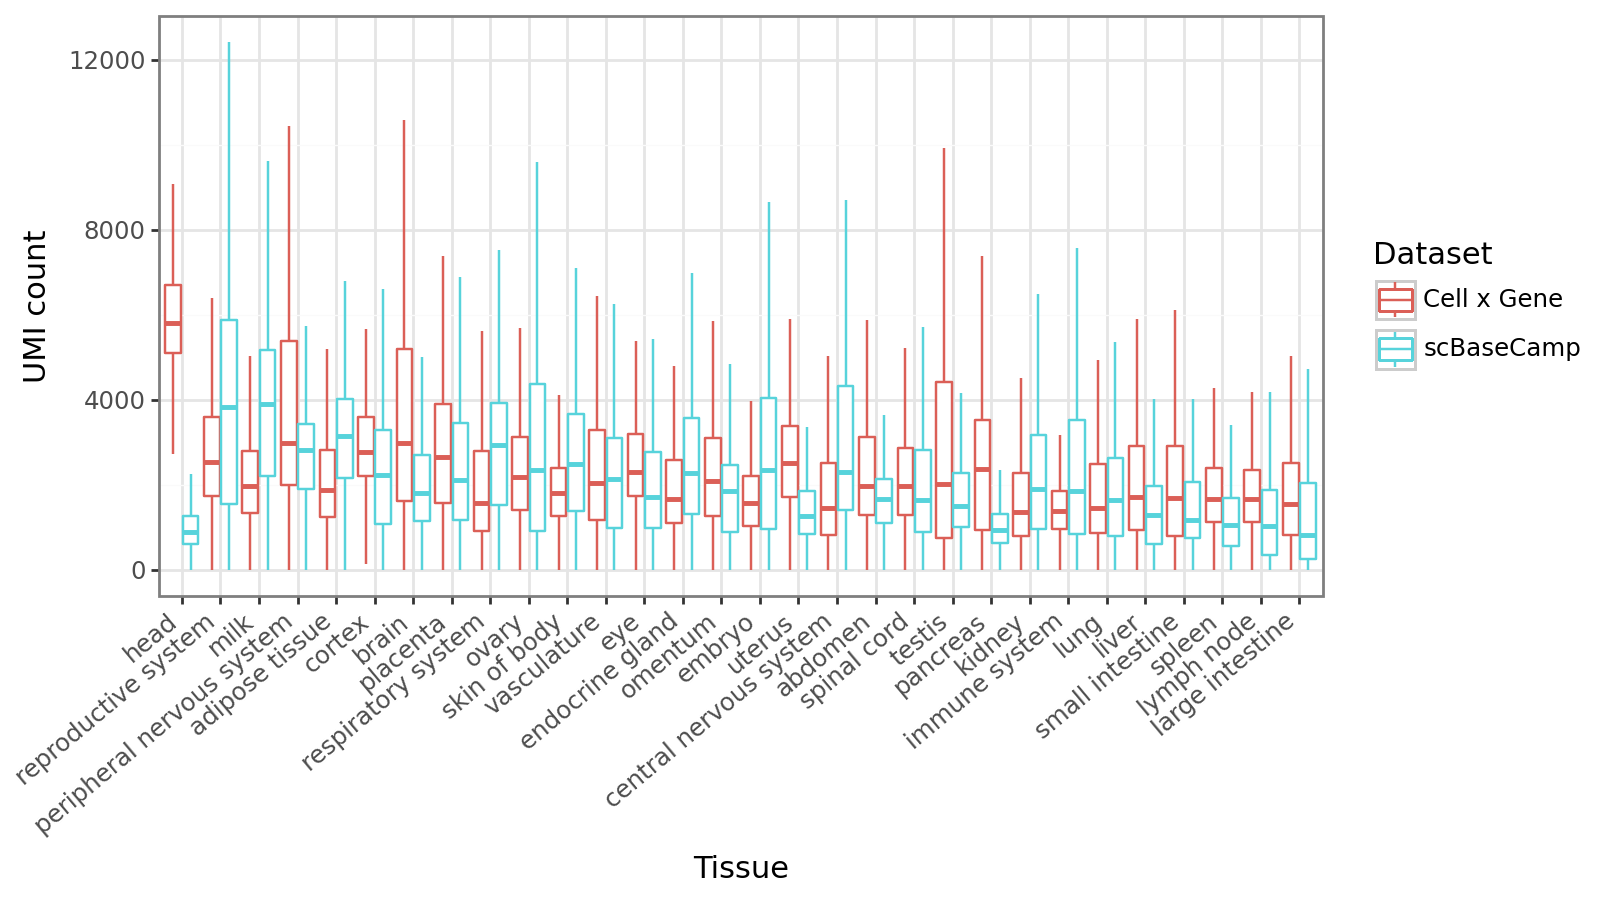

In [ ]:
# Plot using pre-calculated statistics
p = (
    pn.ggplot(box_stats, pn.aes(x='tissue', color='dataset')) + 
    pn.geom_boxplot(
        pn.aes(ymin='ymin', lower='lower', middle='middle', upper='upper', ymax='ymax'), 
        stat='identity'
    ) +
    pn.labs(x="Tissue", y="Gene count", color="Dataset") +
    pn.theme(
        figure_size=(8, 4.5),
        axis_text_x=pn.element_text(angle=40, hjust=1)
    )
)
p

In [42]:
# save as svg
p.save("tissue_gene_count.svg", format="svg")

/home/nickyoungblut/miniforge3/envs/tiledb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 8 x 4.5 in image.
/home/nickyoungblut/miniforge3/envs/tiledb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: tissue_gene_count.svg


### UMI count

In [8]:
target_col = "umi_count"

In [9]:
# combine
all_metadata = pd.concat([
    scbc_metadata, #.head(n=1000000),
    cxg_metadata, #.head(n=1000000)
])
all_metadata = all_metadata[all_metadata["tissue"] != "other"]

print(all_metadata.shape)
all_metadata.head()

(157122985, 6)


,organism,gene_count,umi_count,dataset,tissue,index
0,Macaca mulatta,2653,5818.0,scBaseCamp,lung,NaN
1,Macaca mulatta,384,613.0,scBaseCamp,lung,NaN
2,Macaca mulatta,1667,2901.0,scBaseCamp,lung,NaN
3,Macaca mulatta,569,912.0,scBaseCamp,lung,NaN
4,Macaca mulatta,4905,13947.0,scBaseCamp,lung,NaN


In [10]:
# filter tissues not found in both datasets
to_rm = all_metadata.drop_duplicates(["tissue", "dataset"]).groupby(["tissue"]).size().to_frame().reset_index().rename(columns={0 : "count"})
to_rm = to_rm[to_rm["count"] < 2]["tissue"].unique()    

## filter
all_metadata = all_metadata[~all_metadata["tissue"].isin(to_rm)]
print(all_metadata.shape)
all_metadata.head()

(143764153, 6)


,organism,gene_count,umi_count,dataset,tissue,index
0,Macaca mulatta,2653,5818.0,scBaseCamp,lung,NaN
1,Macaca mulatta,384,613.0,scBaseCamp,lung,NaN
2,Macaca mulatta,1667,2901.0,scBaseCamp,lung,NaN
3,Macaca mulatta,569,912.0,scBaseCamp,lung,NaN
4,Macaca mulatta,4905,13947.0,scBaseCamp,lung,NaN


In [11]:
# agg by tissue and get median
all_metadata_s = all_metadata.groupby(["tissue"]).agg({target_col: "median"}).reset_index()
print(all_metadata_s.shape)
all_metadata_s.head()

(36, 2)


,tissue,umi_count
0,abdomen,5467.5
1,adipose tissue,3848.0
2,blood,3260.0
3,bone marrow,3902.0
4,brain,7110.0


In [12]:
# filter to top 30 tissues
top_n = all_metadata_s.sort_values(target_col, ascending=False)["tissue"].unique()[:30]
all_metadata = all_metadata[all_metadata["tissue"].isin(top_n)]
all_metadata

,organism,gene_count,umi_count,dataset,tissue,index
0,Macaca mulatta,2653,5818.0,scBaseCamp,lung,NaN
1,Macaca mulatta,384,613.0,scBaseCamp,lung,NaN
2,Macaca mulatta,1667,2901.0,scBaseCamp,lung,NaN
3,Macaca mulatta,569,912.0,scBaseCamp,lung,NaN
4,Macaca mulatta,4905,13947.0,scBaseCamp,lung,NaN
...,...,...,...,...,...,...
118717674,Mus musculus,4737,14129.0,Cell x Gene,brain,12599507.0
118717675,Mus musculus,5250,17296.0,Cell x Gene,brain,12599508.0
118717676,Mus musculus,3316,6630.0,Cell x Gene,brain,12599509.0
118717677,Mus musculus,3798,8906.0,Cell x Gene,brain,12599510.0


In [13]:
# add median column, agg by tissue
all_metadata['median'] = all_metadata.groupby('tissue')[target_col].transform('median')
print(all_metadata.shape)
all_metadata.head()

(98386958, 7)


,organism,gene_count,umi_count,dataset,tissue,index,median
0,Macaca mulatta,2653,5818.0,scBaseCamp,lung,NaN,3791.0
1,Macaca mulatta,384,613.0,scBaseCamp,lung,NaN,3791.0
2,Macaca mulatta,1667,2901.0,scBaseCamp,lung,NaN,3791.0
3,Macaca mulatta,569,912.0,scBaseCamp,lung,NaN,3791.0
4,Macaca mulatta,4905,13947.0,scBaseCamp,lung,NaN,3791.0


In [25]:
# calculate boxplot values by tissue and dataset
box_stats = (
    all_metadata.groupby(['tissue', 'dataset'])[target_col]
    .describe(percentiles=[0.25, 0.5, 0.75])
    .reset_index()
).rename({"25%" : "lower", "50%" : "middle", "75%" : "upper"}, axis=1)
# calc IQR
box_stats["iqr"] = box_stats["upper"] - box_stats["lower"]
# calc whiskers
box_stats["ymin"] = box_stats["lower"] - 1.5 * box_stats["iqr"]
box_stats["ymin"] = box_stats["ymin"].apply(lambda x: 0 if x < 0 else x)
box_stats["ymax"] = box_stats["upper"] + 1.5 * box_stats["iqr"]

# results
print(box_stats.shape)
box_stats.head()

(60, 13)


,tissue,dataset,count,mean,std,min,lower,middle,upper,max,iqr,ymin,ymax
0,abdomen,Cell x Gene,414553.0,8405.307816,9541.161420,984.0,3061.00,5523.0,10871.00,396929.0,7810.0,0.0,22586.0
1,abdomen,scBaseCamp,6939.0,4409.015420,2751.374923,501.0,2312.00,4088.0,5909.00,28651.0,3597.0,0.0,11304.5
2,adipose tissue,Cell x Gene,1515281.0,35635.625172,344232.822933,85.0,2016.00,3784.0,7451.00,48453080.0,5435.0,0.0,15603.5
3,adipose tissue,scBaseCamp,31830.0,11010.820138,7640.579539,500.0,5544.25,10387.5,14917.75,116572.0,9373.5,0.0,28978.0
4,blood,Cell x Gene,12750527.0,4684.480723,37198.883507,6.0,2113.00,3375.0,5184.00,13465335.0,3071.0,0.0,9790.5


In [28]:
# agg by tissue and get median
box_stats_s = box_stats.groupby(["tissue"]).agg({"middle": "mean"}).reset_index()

## sort by median
box_stats['tissue'] = pd.Categorical(
    box_stats['tissue'], 
    categories=box_stats_s.sort_values('middle', ascending=False)['tissue'].unique().tolist(), 
    ordered=True
)

print(box_stats.shape)
box_stats.head()

(60, 13)


,tissue,dataset,count,mean,std,min,lower,middle,upper,max,iqr,ymin,ymax
0,abdomen,Cell x Gene,414553.0,8405.307816,9541.161420,984.0,3061.00,5523.0,10871.00,396929.0,7810.0,0.0,22586.0
1,abdomen,scBaseCamp,6939.0,4409.015420,2751.374923,501.0,2312.00,4088.0,5909.00,28651.0,3597.0,0.0,11304.5
2,adipose tissue,Cell x Gene,1515281.0,35635.625172,344232.822933,85.0,2016.00,3784.0,7451.00,48453080.0,5435.0,0.0,15603.5
3,adipose tissue,scBaseCamp,31830.0,11010.820138,7640.579539,500.0,5544.25,10387.5,14917.75,116572.0,9373.5,0.0,28978.0
4,blood,Cell x Gene,12750527.0,4684.480723,37198.883507,6.0,2113.00,3375.0,5184.00,13465335.0,3071.0,0.0,9790.5


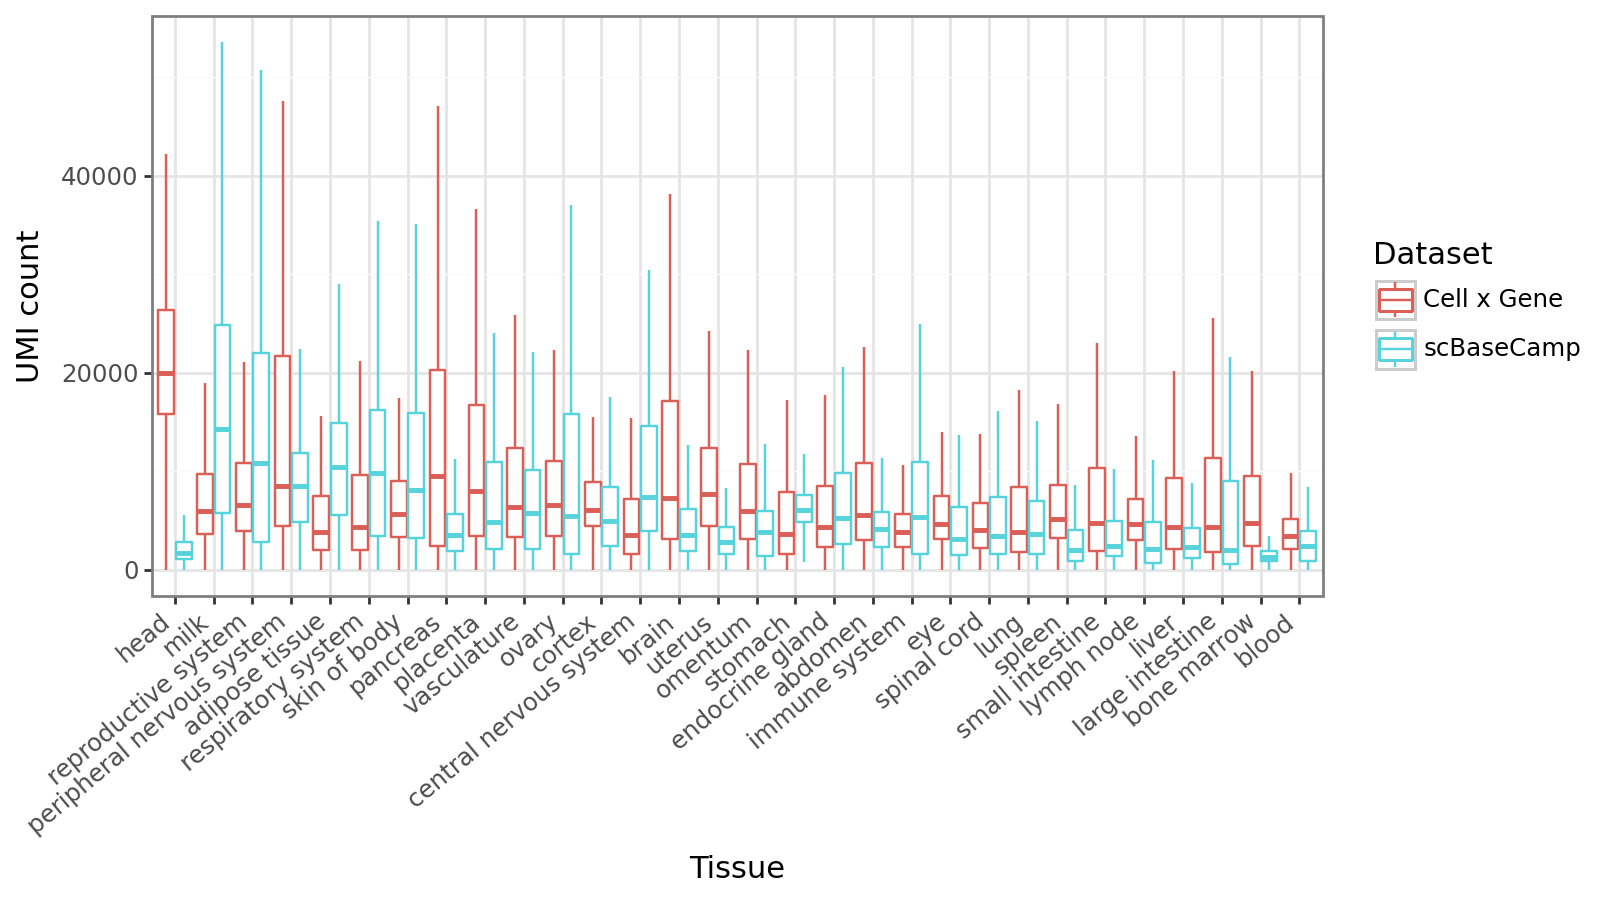

In [29]:
# Plot using pre-calculated statistics
p = (
    pn.ggplot(box_stats, pn.aes(x='tissue', color='dataset')) + 
    pn.geom_boxplot(
        pn.aes(ymin='ymin', lower='lower', middle='middle', upper='upper', ymax='ymax'), 
        stat='identity'
    ) +
    pn.labs(x="Tissue", y="UMI count", color="Dataset") +
    pn.theme(
        figure_size=(8, 4.5),
        axis_text_x=pn.element_text(angle=40, hjust=1)
    )
)
p

In [30]:
# save as svg
p.save("tissue_umi_count.svg", format="svg")

/home/nickyoungblut/miniforge3/envs/tiledb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 8 x 4.5 in image.
/home/nickyoungblut/miniforge3/envs/tiledb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: tissue_umi_count.svg


# Var comparison

In [8]:
with cellxgene_census.open_soma(census_version="2025-01-30") as census:
    print(census["census_data"]["homo_sapiens"].ms["RNA"].var.schema)

soma_joinid: int64 not null
feature_id: large_string
feature_name: large_string
feature_type: large_string
feature_length: int64
nnz: int64
n_measured_obs: int64


In [11]:
# load cell x gene var metadata
target_cols = ["feature_id", "feature_name", "feature_type"]

cxg_var_metadata = []
for organism in ["homo_sapiens", "mus_musculus"]:
    with cellxgene_census.open_soma(census_version="2025-01-30") as census:
        df = (
            census["census_data"][organism].ms["RNA"].var
            .read(column_names=target_cols).concat().to_pandas()
        )
        df["organism"] = organism
        cxg_var_metadata.append(df)

cxg_var_metadata = pd.concat(cxg_var_metadata).reset_index()
cxg_var_metadata

,index,feature_id,feature_name,feature_type,organism
0,0,ENSG00000237491,LINC01409,lncRNA,homo_sapiens
1,1,ENSG00000188976,NOC2L,protein_coding,homo_sapiens
2,2,ENSG00000187642,PERM1,protein_coding,homo_sapiens
3,3,ENSG00000272512,ENSG00000272512.1,lncRNA,homo_sapiens
4,4,ENSG00000188290,HES4,protein_coding,homo_sapiens
...,...,...,...,...,...
114366,52478,ENSMUSG00002076971,Snord100,snoRNA,mus_musculus
114367,52479,ENSMUSG00002076818,Snord14e,snoRNA,mus_musculus
114368,52480,ENSMUSG00002076766,Snord33,snoRNA,mus_musculus
114369,52481,ENSMUSG00000118645,Gm55062,lncRNA,mus_musculus


In [35]:
# just human genes
df_hg = cxg_var_metadata[cxg_var_metadata["organism"] == "homo_sapiens"].reset_index()
df_hg

,level_0,index,feature_id,feature_name,feature_type,organism
0,0,0,ENSG00000237491,LINC01409,lncRNA,homo_sapiens
1,1,1,ENSG00000188976,NOC2L,protein_coding,homo_sapiens
2,2,2,ENSG00000187642,PERM1,protein_coding,homo_sapiens
3,3,3,ENSG00000272512,ENSG00000272512.1,lncRNA,homo_sapiens
4,4,4,ENSG00000188290,HES4,protein_coding,homo_sapiens
...,...,...,...,...,...,...
61883,61883,61883,ENSG00000291050,TEKT4P2_ENSG00000291050,lncRNA,homo_sapiens
61884,61884,61884,ENSG00000290376,HERC2P3_ENSG00000290376,lncRNA,homo_sapiens
61885,61885,61885,ENSG00000292362,CD99P1_ENSG00000292362,lncRNA,homo_sapiens
61886,61886,61886,ENSG00000292367,ELOCP24_ENSG00000292367,processed_pseudogene,homo_sapiens


In [21]:
# just the filtering that we did for mammals
types_to_keep =  [
    "protein_coding", 
    "protein_coding_LoF", 
    "lncRNA", 
    "antisense",
    "IG_C_gene", 
    "IG_D_gene", 
    "IG_J_gene", 
    "IG_LV_gene", 
    "IG_V_gene", 
    "IG_V_pseudogene", 
    "IG_J_pseudogene", 
    "IG_C_pseudogene", 
    "TR_C_gene", 
    "TR_D_gene", 
    "TR_J_gene", 
    "TR_V_gene", 
    "TR_V_pseudogene", 
    "TR_J_pseudogene"
]

df_hg_f = df_hg[df_hg["feature_type"].isin(types_to_keep)].reset_index()
df_hg_f

,level_0,index,feature_id,feature_name,feature_type,organism
0,0,0,ENSG00000237491,LINC01409,lncRNA,homo_sapiens
1,1,1,ENSG00000188976,NOC2L,protein_coding,homo_sapiens
2,2,2,ENSG00000187642,PERM1,protein_coding,homo_sapiens
3,3,3,ENSG00000272512,ENSG00000272512.1,lncRNA,homo_sapiens
4,4,4,ENSG00000188290,HES4,protein_coding,homo_sapiens
...,...,...,...,...,...,...
38722,61881,61881,ENSG00000290649,OR51H1_ENSG00000290649,lncRNA,homo_sapiens
38723,61882,61882,ENSG00000290330,FAM197Y5_ENSG00000290330,lncRNA,homo_sapiens
38724,61883,61883,ENSG00000291050,TEKT4P2_ENSG00000291050,lncRNA,homo_sapiens
38725,61884,61884,ENSG00000290376,HERC2P3_ENSG00000290376,lncRNA,homo_sapiens


In [26]:
db_uri = "/scratch/multiomics/nickyoungblut/tiledb-loader/tiledb-soma_GeneFull_Ex50pAS"
# read in var metadata
with tiledbsoma.Experiment.open(db_uri) as exp:
    df_scbc_var = (
        exp.ms["RNA"]
        .var.read()
        .concat()
        .to_pandas()
    )

df_scbc_var = df_scbc_var[df_scbc_var["var_id"].str.startswith("ENSG")].reset_index()
df_scbc_var

,index,soma_joinid,var_id
0,0,0,ENSG00000000003
1,1,1,ENSG00000000005
2,2,2,ENSG00000000419
3,3,3,ENSG00000000457
4,4,4,ENSG00000000460
...,...,...,...
36596,36596,36596,ENSG00000288380
36597,36597,36597,ENSG00000288398
36598,36598,36598,ENSG00000288436
36599,36599,36599,ENSG00000288459


In [30]:
# left join
df_scbc_var_j = pd.merge(df_scbc_var["var_id"], df_hg, left_on="var_id", right_on="feature_id", how="left")
df_scbc_var_j

,var_id,index,feature_id,feature_name,feature_type,organism
0,ENSG00000000003,5363.0,ENSG00000000003,TSPAN6,protein_coding,homo_sapiens
1,ENSG00000000005,12641.0,ENSG00000000005,TNMD,protein_coding,homo_sapiens
2,ENSG00000000419,11182.0,ENSG00000000419,DPM1,protein_coding,homo_sapiens
3,ENSG00000000457,987.0,ENSG00000000457,SCYL3,protein_coding,homo_sapiens
4,ENSG00000000460,12642.0,ENSG00000000460,C1orf112,protein_coding,homo_sapiens
...,...,...,...,...,...,...
36596,ENSG00000288380,NaN,NaN,NaN,NaN,NaN
36597,ENSG00000288398,33392.0,ENSG00000288398,ENSG00000288398.1,lncRNA,homo_sapiens
36598,ENSG00000288436,NaN,NaN,NaN,NaN,NaN
36599,ENSG00000288459,36055.0,ENSG00000288459,ENSG00000288459.1,lncRNA,homo_sapiens


In [32]:
df_scbc_var_j["feature_type"].value_counts()

feature_type
protein_coding                        19253
lncRNA                                16421
IG_V_pseudogene                         187
IG_V_gene                               145
TR_V_gene                               106
TR_J_gene                                79
IG_D_gene                                37
TR_V_pseudogene                          33
transcribed_unprocessed_pseudogene       29
IG_J_gene                                18
transcribed_unitary_pseudogene           17
artifact                                 17
IG_C_gene                                14
IG_C_pseudogene                           9
TR_C_gene                                 6
TR_D_gene                                 4
TR_J_pseudogene                           4
IG_J_pseudogene                           3
unprocessed_pseudogene                    2
transcribed_processed_pseudogene          2
processed_pseudogene                      2
unitary_pseudogene                        1
TEC                

In [39]:
# left join
df_hg[~df_hg["feature_id"].isin(df_scbc_var["var_id"])]["feature_type"].value_counts()

feature_type
processed_pseudogene                  10145
unprocessed_pseudogene                 2604
misc_RNA                               2221
snRNA                                  1910
miRNA                                  1879
lncRNA                                 1615
TEC                                    1052
snoRNA                                  942
transcribed_unprocessed_pseudogene      932
protein_coding                          792
transcribed_processed_pseudogene        510
rRNA_pseudogene                         497
transcribed_unitary_pseudogene          137
unitary_pseudogene                       96
rRNA                                     53
scaRNA                                   49
Mt_tRNA                                  22
pseudogene                               19
ribozyme                                  8
sRNA                                      5
translated_processed_pseudogene           2
artifact                                  2
Mt_rRNA            

In [33]:
# dataframe provided by Richard from Vevo
df_vevo_tahoe100 = pd.read_csv("data/2025-02-14_vevo_tahoe-100_anndata_var.csv")
df_vevo_tahoe100

,gene_name,gene_id,genome
0,TSPAN6,ENSG00000000003,hg38
1,TNMD,ENSG00000000005,hg38
2,DPM1,ENSG00000000419,hg38
3,SCYL3,ENSG00000000457,hg38
4,C1orf112,ENSG00000000460,hg38
...,...,...,...
62705,ENSG00000291313,ENSG00000291313,hg38
62706,ENSG00000291314,ENSG00000291314,hg38
62707,ENSG00000291315,ENSG00000291315,hg38
62708,ENSG00000291316,ENSG00000291316,hg38


In [36]:
df_vevo_tahoe100["gene_id"].isin(df_hg["feature_id"]).sum()

61850

# sessionInfo

In [1]:
!pip list

Package                     Version
--------------------------- -----------
aiobotocore                 2.19.0
aiohappyeyeballs            2.4.4
aiohttp                     3.11.11
aioitertools                0.12.0
aiosignal                   1.3.2
anndata                     0.11.3
array_api_compat            1.10.0
asttokens                   3.0.0
attrs                       25.1.0
beautifulsoup4              4.13.3
botocore                    1.36.3
Brotli                      1.1.0
cached-property             1.5.2
cachetools                  5.5.1
cellxgene-census            1.16.2
certifi                     2024.12.14
cffi                        1.17.1
charset-normalizer          3.4.1
colorama                    0.4.6
comm                        0.2.2
contourpy                   1.3.1
cryptography                44.0.0
cycler                      0.12.1
debugpy                     1.8.12
decorator                   5.1.1
exceptiongroup              1.2.2
executing            